<a href="https://colab.research.google.com/github/Doppler-67/HackWagon22/blob/main/wagons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [2]:
sns.set()

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
xgb_device = "gpu_hist" if torch.cuda.is_available() else "hist"
xgb_device

'gpu_hist'

# **Data understanding**

In [5]:
data = pd.read_parquet('/content/drive/MyDrive/hackwagon22/df_train.parquet')

In [6]:
test = pd.read_parquet('/content/drive/MyDrive/hackwagon22/df_test.parquet')

In [7]:
data.head()

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y
0,wagonwagonwagontutu:)wagon,wagondigitalnewyearrailway:)happy,2021,11,45,12,14,3399.0,4.0,1,2,11.0,102.0,930.0,1098,5476,13,13,78,75,185.200000
1,railwaypgkhappyrailway:)railway,digitalhappynewyeardigital:)wagon,2021,4,15,17,16,2261.0,3.0,0,8,9.0,111.0,16.0,2974,6682,21,21,111,111,0.250000
2,railwaytutupgkpgk:)digital,pgkdigitalrailway:):)happy,2021,5,17,2,7,1089.0,3.0,1,8,9.0,111.0,879.0,2082,10729,9,9,67,23,109.133333
3,tuturailwaydigital2022:)digital,newyearnewyear20222022:)2022,2020,11,47,17,11,2261.0,4.0,0,8,975.0,103.0,8569.0,2974,10571,28,28,115,112,214.093056
4,railwaytutupgkpgk:)digital,pgkhappyrailwayhack:)railway,2020,12,52,25,5,1666.0,4.0,1,8,9.0,101.0,656.0,2082,9225,9,9,67,16,104.100000


In [8]:
test.head()

,st_code_snd,st_code_rsv,date_depart_year,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,fr_id,route_type,is_load,rod,common_ch,vidsobst,distance,snd_org_id,rsv_org_id,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id
0,happy:)pgkwagon:):),pgk2022newyear:)pgk,2022,9,35,1,9,2261.0,3.0,0,2,10.0,102.0,2930.0,2974,2847,28,28,134,125
1,2022newyear:)newyear:):),hacktutu:)newyear:)2022,2022,8,34,22,14,1653.0,4.0,1,8,9.0,102.0,1728.0,2957,6340,18,18,102,16
2,happyrailwaytutu:)pgk,newyeartutu:)hack:)newyear,2022,5,21,26,16,643.0,3.0,1,8,9.0,102.0,4393.0,1664,2128,0,0,1,124
3,2022tuturailwayhack:):),2022newyear:)happy:)pgk,2022,11,44,4,4,2261.0,4.0,0,8,975.0,111.0,1111.0,2974,2468,32,32,29,31
4,happyrailwaytutu:)pgk,pgk2022newyear:)pgk,2022,5,20,17,6,2261.0,3.0,0,15,40.0,111.0,19.0,2974,1098,29,29,117,117


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4219370 entries, 0 to 4219369
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   st_code_snd        object 
 1   st_code_rsv        object 
 2   date_depart_year   int64  
 3   date_depart_month  int64  
 4   date_depart_week   int64  
 5   date_depart_day    int64  
 6   date_depart_hour   int64  
 7   fr_id              float64
 8   route_type         float64
 9   is_load            int64  
 10  rod                int64  
 11  common_ch          float64
 12  vidsobst           float64
 13  distance           float64
 14  snd_org_id         int64  
 15  rsv_org_id         int64  
 16  snd_roadid         int32  
 17  rsv_roadid         int32  
 18  snd_dp_id          int64  
 19  rsv_dp_id          int64  
 20  y                  float64
dtypes: float64(6), int32(2), int64(11), object(2)
memory usage: 643.8+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182903 entries, 0 to 1182902
Data columns (total 20 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   st_code_snd        1182903 non-null  object 
 1   st_code_rsv        1182903 non-null  object 
 2   date_depart_year   1182903 non-null  int64  
 3   date_depart_month  1182903 non-null  int64  
 4   date_depart_week   1182903 non-null  int64  
 5   date_depart_day    1182903 non-null  int64  
 6   date_depart_hour   1182903 non-null  int64  
 7   fr_id              1182857 non-null  float64
 8   route_type         1182903 non-null  float64
 9   is_load            1182903 non-null  int64  
 10  rod                1182903 non-null  int64  
 11  common_ch          1143831 non-null  float64
 12  vidsobst           1165775 non-null  float64
 13  distance           1170936 non-null  float64
 14  snd_org_id         1182903 non-null  int64  
 15  rsv_org_id         1182903 non-n

In [11]:
data.isna().sum()

st_code_snd               0
st_code_rsv               0
date_depart_year          0
date_depart_month         0
date_depart_week          0
date_depart_day           0
date_depart_hour          0
fr_id                   377
route_type             3430
is_load                   0
rod                       0
common_ch            103842
vidsobst             103917
distance              38771
snd_org_id                0
rsv_org_id                0
snd_roadid                0
rsv_roadid                0
snd_dp_id                 0
rsv_dp_id                 0
y                         0
dtype: int64

In [12]:
test.isna().sum()

st_code_snd              0
st_code_rsv              0
date_depart_year         0
date_depart_month        0
date_depart_week         0
date_depart_day          0
date_depart_hour         0
fr_id                   46
route_type               0
is_load                  0
rod                      0
common_ch            39072
vidsobst             17128
distance             11967
snd_org_id               0
rsv_org_id               0
snd_roadid               0
rsv_roadid               0
snd_dp_id                0
rsv_dp_id                0
dtype: int64

Доступно 4.22 млн. строк данных для обучения. Есть пропуски в фитчах: fr_id, route_type, common_ch, vidsobst, distance.

В тестовой выборке доступно 1.18 млн. строк. Есть пропуски в фитчах: fr_id, common_ch, vidsobst, distance.

# **Data preparation**

In [13]:
data['date_depart_year'].value_counts()

2021    2346093
2020    1140600
2022     725173
2019       7504
Name: date_depart_year, dtype: int64

In [14]:
data.groupby('date_depart_year')['y'].describe()

,count,mean,std,min,25%,50%,75%,max
date_depart_year,,,,,,,,
2019,7504.0,235.805877,681.723065,0.066667,61.833333,109.425000,174.358333,10936.768056
2020,1140600.0,105.889101,126.112025,0.000000,34.500000,78.933333,143.433333,9519.000000
2021,2346093.0,102.928504,115.833900,0.000000,20.150000,73.283333,147.933333,7853.930000
2022,725173.0,116.249268,137.634744,0.000000,22.233333,78.750000,164.965833,4605.850000


In [15]:
test['date_depart_year'].value_counts()

2022    1182903
Name: date_depart_year, dtype: int64

Так как в тестовом наборе только 22 год, в фитче date_depart_year, а в обучающем наборе есть 19-22 года, то эту фитчу не будем использовать. В 19 году слишком мало данных, а 20 год мог быть аномальным из-за ковида, поэтому обучаться будем только на 21-22 годах. (обучение только на 21-22 годах показало себя лучше всего на тестовой выборке)

In [16]:
data = data[(data['date_depart_year'] != 2019) & (data['date_depart_year'] != 2020)]

Если внимательно изучить фитчи st_code_snd и st_code_rsv, то на первый взгляд они кажутся бесполезными, но если их закодировать и использовать при обучении, то результат улучшается, но не сильно, но это все равно значит, что какую-то пользу они приносят.

Эти фитчи состоят из комбинаций одних и тех же слов: happy, pgk, wagon, tutu, newyear, digital, hack, railway, 2022 и разделителя в виде смайлика ':)'. Поэтому было решено создать бинарные фитчи, которые показывают наличие опредленных слов в этих фитчах. (Этот подход принес колоссальный прирост по метрике и наша команда поднялась на 9 место)

In [17]:
data['snd_rsv'] = data['st_code_snd'] + data['st_code_rsv']

In [18]:
new_features = ['happy', 'pgk', 'wagon', 'tutu', 'newyear', 'digital', 'hack', 'railway', '2022']

In [19]:
for i in new_features:
  data[i] = 0

In [20]:
for s in new_features:
  data[s] = data['snd_rsv'].apply(lambda x: True if s in x else False)

Удалим ненужные для обучения фитчи.

In [21]:
data = data.drop(['st_code_snd', 'st_code_rsv','fr_id', 'common_ch', 'vidsobst', 'snd_org_id', 'rsv_org_id', 'date_depart_year', 'snd_rsv'], axis=1).reset_index(drop=True)

In [22]:
data.head()

,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,route_type,is_load,rod,distance,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,y,happy,pgk,wagon,tutu,newyear,digital,hack,railway,2022
0,11,45,12,14,4.0,1,2,930.0,13,13,78,75,185.200000,True,False,True,True,True,True,False,True,False
1,4,15,17,16,3.0,0,8,16.0,21,21,111,111,0.250000,True,True,True,False,True,True,False,True,False
2,5,17,2,7,3.0,1,8,879.0,9,9,67,23,109.133333,True,True,False,True,False,True,False,True,False
3,5,21,28,11,1.0,0,8,1021.0,23,23,10,67,49.150000,True,True,True,False,True,False,True,True,False
4,1,2,14,11,1.0,0,8,4480.0,6,6,59,111,129.400000,True,True,True,True,True,False,True,True,False


# **EDA**

Изучим фитчу date_depart_month.

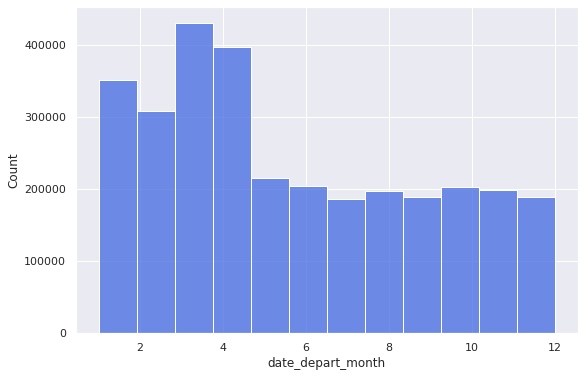

In [23]:
plt.figure(figsize=(9,6))
sns.histplot(data['date_depart_month'], bins=12, color='royalblue')
plt.show()

Изучим фитчу date_depart_week.

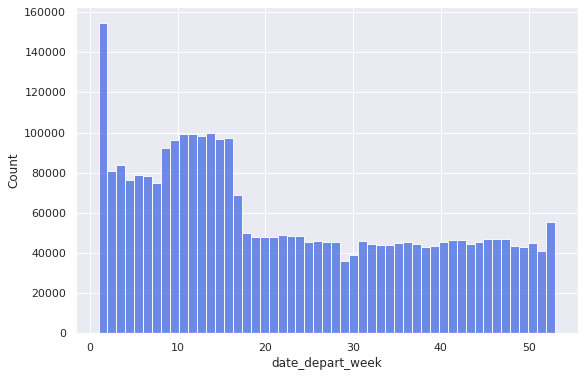

In [24]:
plt.figure(figsize=(9,6))
sns.histplot(data['date_depart_week'], bins=51, color='royalblue')
plt.show()

Изучим фитчу date_depart_day.

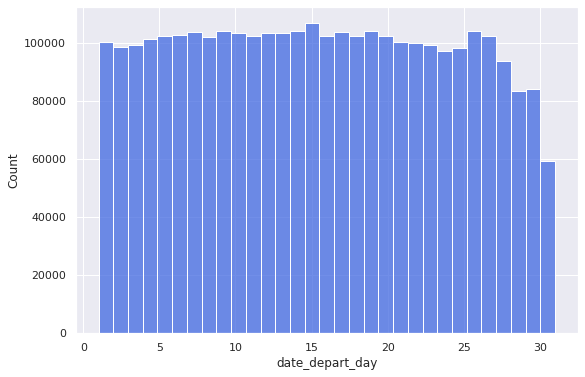

In [25]:
plt.figure(figsize=(9,6))
sns.histplot(data['date_depart_day'], bins=31, color='royalblue')
plt.show()

Изучим фитчу date_depart_hour.

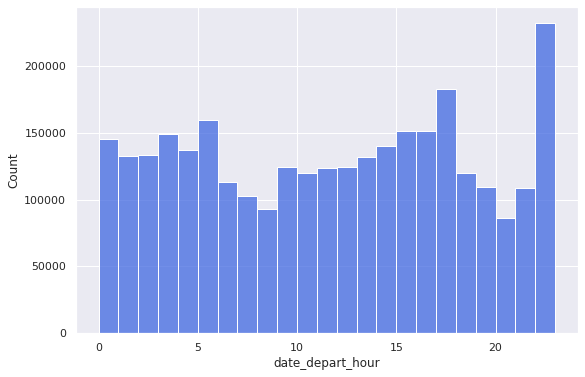

In [26]:
plt.figure(figsize=(9,6))
sns.histplot(data['date_depart_hour'], bins=23, color='royalblue')
plt.show()

Изучим фитчу route_type.

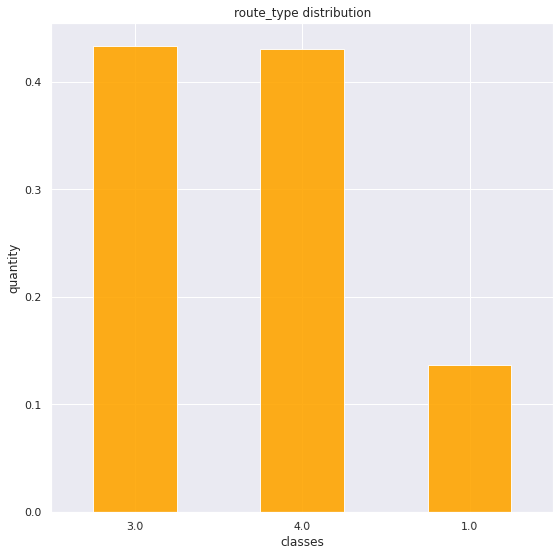

In [27]:

data['route_type'].value_counts(normalize=True).plot(kind='bar', title='route_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(9, 9))
plt.show()

Изучим фитчу is_load.

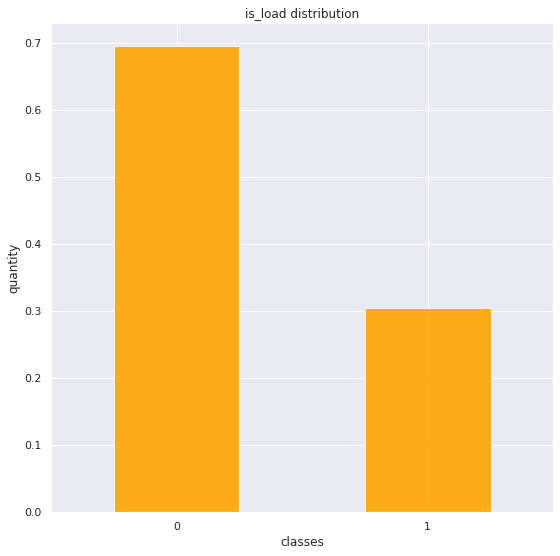

In [28]:
data['is_load'].value_counts(normalize=True).plot(kind='bar', title='is_load distribution', xlabel='classes', 
                                    ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(9, 9))
plt.show()

Изучим фитчу rod.

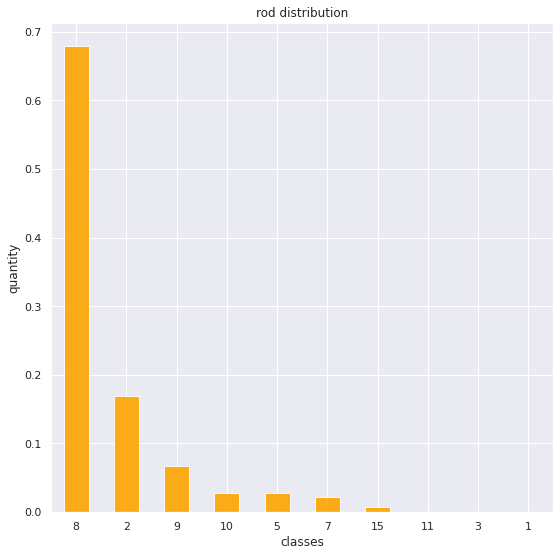

In [29]:
data['rod'].value_counts(normalize=True).plot(kind='bar', title='rod distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(9, 9))
plt.show()

Изучим dsitance.

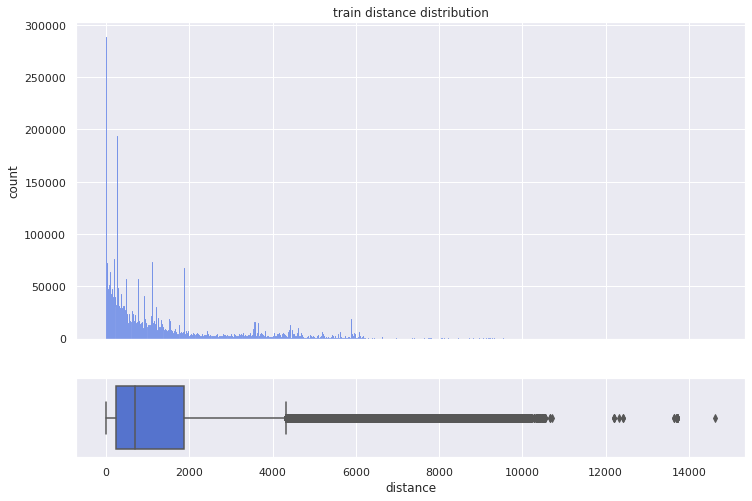

In [30]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['distance'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['distance'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='distance')
ax_hist.set(ylabel='count')
ax_hist.set(title='train distance distribution')
plt.show()

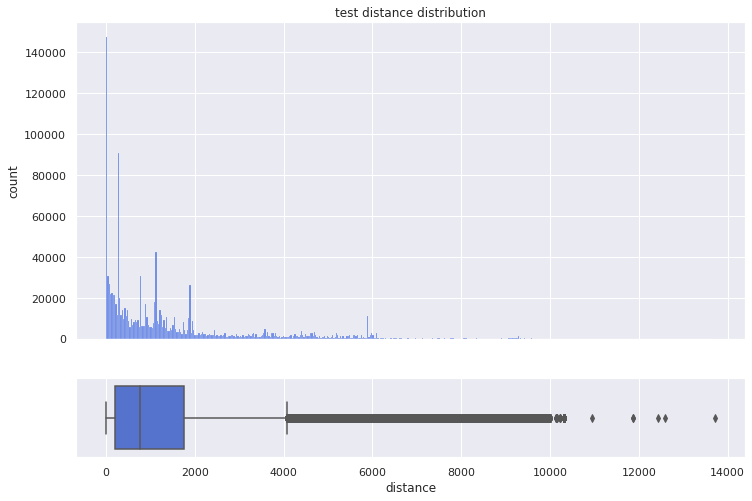

In [31]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=test['distance'], ax=ax_hist, color='royalblue')
sns.boxplot(x=test['distance'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='distance')
ax_hist.set(ylabel='count')
ax_hist.set(title='test distance distribution')
plt.show()

Дистанция распределена экпоненциально.

Очень много выбросов. В тесте самое большое значение не больше 14000, поэтому удалим в трейне все строки где distance > 14000.

In [32]:
data = data[data['distance'] <= 14000]

Изучим таргет.

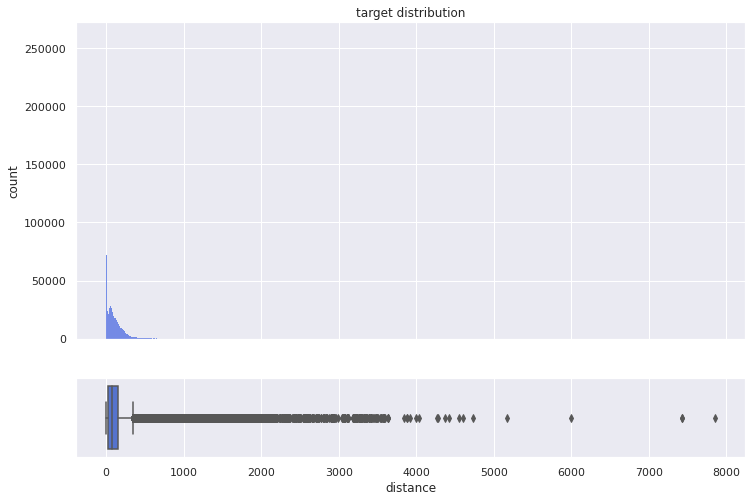

In [33]:
fig, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .2)}, figsize=(12, 8))

sns.histplot(x=data['y'], ax=ax_hist, color='royalblue')
sns.boxplot(x=data['y'], ax=ax_box, color='royalblue')

ax_box.set(xlabel='distance')
ax_hist.set(ylabel='count')
ax_hist.set(title='target distribution')
plt.show()

In [34]:
pd.DataFrame(data['y'].describe()).T

,count,mean,std,min,25%,50%,75%,max
y,3058766.0,106.112867,121.431953,0.0,20.6425,74.516667,151.661042,7853.93


Распределение экспоненциальное. Очень много выбросов и странных значений, например 0.

Как нам сказали организаторы - таргет заполнялся вручную людьми и они могли случайно ввести некорректное значение. Так как в тесте, вероятно, такая же ситуация, то ничего делать с этим не будем.

# **Modeling**

Приступим к машинному обучения.

In [35]:
x, y = data.drop('y', axis=1), data['y'] 

In [36]:
x.head()

,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,route_type,is_load,rod,distance,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,happy,pgk,wagon,tutu,newyear,digital,hack,railway,2022
0,11,45,12,14,4.0,1,2,930.0,13,13,78,75,True,False,True,True,True,True,False,True,False
1,4,15,17,16,3.0,0,8,16.0,21,21,111,111,True,True,True,False,True,True,False,True,False
2,5,17,2,7,3.0,1,8,879.0,9,9,67,23,True,True,False,True,False,True,False,True,False
3,5,21,28,11,1.0,0,8,1021.0,23,23,10,67,True,True,True,False,True,False,True,True,False
4,1,2,14,11,1.0,0,8,4480.0,6,6,59,111,True,True,True,True,True,False,True,True,False


За бейзлайн возьмем xgboost с дефолтными параметрами.

In [37]:
model = XGBRegressor(random_state=67, objective='reg:squarederror', tree_method=xgb_device)

In [38]:
res = cross_val_score(model, x, y, cv=5, scoring='neg_root_mean_squared_error')
print('mean rmse:', -res.mean())

mean rmse: 81.78447873029748


Создадим сетку параметров и закинем в оптюну.

In [39]:
def objective(trial):

    params = {"max_depth": trial.suggest_int("max_depth", 4, 16),
             'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
             'n_estimators': trial.suggest_int('n_estimators', 100, 1500, log=True),
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 8)
            } 

    model = XGBRegressor(**params, random_state=67, objective='reg:squarederror', tree_method=xgb_device)

    res = cross_val_score(model, x, y, cv=5, scoring='neg_root_mean_squared_error')
    mean_rmse = -res.mean()

    return mean_rmse

In [40]:
sampler = optuna.samplers.TPESampler(seed=67)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=3)

[I 2022-12-23 13:08:26,047] A new study created in memory with name: no-name-018fd2e1-38c8-4fbf-bf52-8c6557425b4a
[I 2022-12-23 13:14:25,867] Trial 0 finished with value: 58.251603255110226 and parameters: {'max_depth': 11, 'learning_rate': 0.13411951209051293, 'n_estimators': 640, 'min_child_weight': 3}. Best is trial 0 with value: 58.251603255110226.
[I 2022-12-23 13:15:13,383] Trial 1 finished with value: 89.20574780270569 and parameters: {'max_depth': 4, 'learning_rate': 0.009054342146682848, 'n_estimators': 177, 'min_child_weight': 8}. Best is trial 0 with value: 58.251603255110226.
[I 2022-12-23 13:38:29,949] Trial 2 finished with value: 83.06282273332849 and parameters: {'max_depth': 13, 'learning_rate': 0.00130666831722875, 'n_estimators': 924, 'min_child_weight': 5}. Best is trial 0 with value: 58.251603255110226.


За все время хакаотона в оптюне было проведено больше 250 итераций.

Для этих данных лучшими параметрами оказались:

*   max_depth=13
*   learning_rate=0.12335384066735672
*   n_estimators=624
*   min_child_weight=6



Посмотрим на результат модели с лучшими гиперпараметрами.

In [41]:
model = XGBRegressor(random_state=67, objective='reg:squarederror', tree_method=xgb_device, max_depth=13,
                     learning_rate=0.12335384066735672, n_estimators=624, min_child_weight=6)

In [42]:
res = cross_val_score(model, x, y, cv=5, scoring='neg_root_mean_squared_error')
print('mean rmse:', -res.mean())

mean rmse: 56.907858767882985


# **Test**

Заполнением пропусков в тесте занимался другой человек. Мы использовали хитрый способ - заполнение модой по группам через двойную группировку. Этот способ показал лучший результат. 

Загружаем уже заполненную тестовую выборку и делаем предикты.

In [43]:
test_set = pd.read_parquet('/content/drive/MyDrive/hackwagon22/df_test_filled.parquet')

Создаем точно такие же бинарные фитчи в тестовом наборе.

In [44]:
test_set['snd_rsv'] = test_set['st_code_snd'] + test_set['st_code_rsv']

In [45]:
for i in new_features:
  test_set[i] = 0

In [46]:
for s in new_features:
  test_set[s] = test_set['snd_rsv'].apply(lambda x: True if s in x else False)

In [47]:
test_set = test_set.drop(['st_code_snd', 'st_code_rsv','fr_id', 'common_ch', 'vidsobst', 'snd_org_id', 
                          'rsv_org_id', 'snd_rsv', 'test', 'date_depart_year'], axis=1)

In [48]:
test_set.head()

,date_depart_month,date_depart_week,date_depart_day,date_depart_hour,route_type,is_load,rod,distance,snd_roadid,rsv_roadid,snd_dp_id,rsv_dp_id,happy,pgk,wagon,tutu,newyear,digital,hack,railway,2022
0,9,35,1,9,3.0,0,2,2930.0,28,28,134,125,True,True,True,False,True,False,False,False,True
1,8,34,22,14,4.0,1,8,1728.0,18,18,102,16,False,False,False,True,True,False,True,False,True
2,5,21,26,16,3.0,1,8,4393.0,0,0,1,124,True,True,False,True,True,False,True,True,False
3,11,44,4,4,4.0,0,8,1111.0,32,32,29,31,True,True,False,True,True,False,True,True,True
4,5,20,17,6,3.0,0,15,19.0,29,29,117,117,True,True,False,True,True,False,False,True,True


In [49]:
model.fit(x, y)

XGBRegressor(learning_rate=0.12335384066735672, max_depth=13,
             min_child_weight=6, n_estimators=624, objective='reg:squarederror',
             random_state=67, tree_method='gpu_hist')

In [50]:
predicts = model.predict(test_set)

In [51]:
time = pd.Series(predicts, name='time')

In [52]:
time[time < 0]

25         -0.263484
41        -12.946443
231        -0.583887
263        -0.664273
310        -0.906949
             ...    
1182681    -0.899317
1182701    -0.143145
1182731    -5.898276
1182744    -1.244939
1182769    -2.999120
Name: time, Length: 32612, dtype: float32

Как оказалось, есть довольно много отрицательных значений, что не может быть в реальности. Для заполнения таких значений было протестировано множество вариантов. Лучшим оказалось значение 0.25.

In [53]:
time[time < 0] = 0.25

Скачиваем csv файл с предиктами и отправляем сабмит на сервер.

In [54]:
time.to_csv('time.csv', index=False)